##### Copyright 2018 The TF-Agents Authors.

### Get Started
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/tf_agents/colabs/1_dqn_tutorial.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/tf_agents/colabs/1_dqn_tutorial.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


# Note: If you haven't installed the following dependencies, run:
!apt-get install xvfb
!pip install 'gym==0.10.11'
!pip install imageio
!pip install PILLOW
!pip install pyglet
!pip install pyvirtualdisplay
!pip install tf-agents-nightly
!pip install tf-nightly

## Introduction

This example shows how to train a [DQN (Deep Q Networks)](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)  agent on the Cartpole environment using the TF-Agents library.

![Cartpole environment](images/cartpole.png)

We will walk you through all the components in a Reinforcement Learning (RL) pipeline for training, evaluation and data collection.


## Setup

In [105]:
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.dqn import q_network
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.environments import trajectory
from tf_agents.metrics import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()


# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyperparameters

In [106]:
env_name = 'MountainCar-v0'  # @param
num_iterations = 20000  # @param

initial_collect_steps = 1000  # @param
collect_steps_per_iteration = 1  # @param
replay_buffer_capacity = 100000  # @param

fc_layer_params = (100,)

batch_size = 64  # @param
learning_rate = 1e-3  # @param
log_interval = 200  # @param

num_eval_episodes = 10  # @param
eval_interval = 1000  # @param

## Environment

Environments in RL represent the task or problem that we are trying to solve. Standard environments can be easily created in TF-Agents using `suites`. We have different `suites` for loading environments from sources such as the OpenAI Gym, Atari, DM Control, etc., given a string environment name.

Now let us load the CartPole environment from the OpenAI Gym suite. 

In [107]:
env = suite_gym.load(env_name)

We can render this environment to see how it looks. A free-swinging pole is attached to a cart.  The goal is to move the cart right or left in order to keep the pole pointing up.

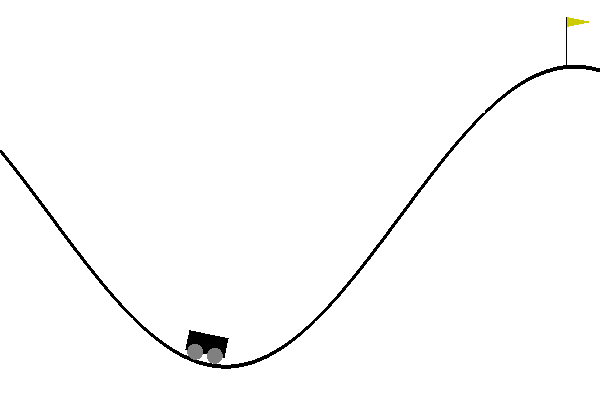

In [108]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

The `time_step = environment.step(action)` statement takes `action` in the environment.  The `TimeStep` tuple returned contains the environment's next observation and reward for that action. The `time_step_spec()` and `action_spec()` methods in the environment return the specifications (types, shapes, bounds) of the `time_step` and `action` respectively.

In [109]:
print("Metadata")

print('\nAction Specification:')
action_spec = env.action_spec()
print(action_spec)

print("Time Step Specification:")
time_step_spec = env.time_step_spec()
print(time_step_spec)

print('\nObservation Specification:')
observation_spec = time_step_spec.observation
print(observation)

print('\nReward Specification:')
reward_spec = time_step_spec.reward
print(reward)

Metadata

Action Specification:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name=None, minimum=0, maximum=2)
Time Step Specification:
TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(2,), dtype=dtype('float32'), name=None, minimum=[-1.2  -0.07], maximum=[0.6  0.07]))

Observation Specification:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name=None, minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])

Reward Specification:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


So, we see that observation is an array of 4 floats: the position and velocity of the cart, and the angular position and velocity of the pole. Since only two actions are possible (move left or move right), the `action_spec` is a scalar where 0 means "move left" and 1 means "move right."

In [110]:
time_step_0 = env.reset()

print('Time Step 0:')
print(time_step_0)

action = 1
time_step_1 = env.step(action)

print('\nTime Step 1:')
print(time_step_1)

action = 0
time_step_2 = env.step(action)

print('\nTime Step 2:')
print(time_step_2)

Time Step 0:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.4855132,  0.       ], dtype=float32))

Time Step 1:
TimeStep(step_type=array(1, dtype=int32), reward=array(-1., dtype=float32), discount=array(1., dtype=float32), observation=array([-4.8579824e-01, -2.8502056e-04], dtype=float32))

Time Step 2:
TimeStep(step_type=array(1, dtype=int32), reward=array(-1., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.48736617, -0.00156792], dtype=float32))


Usually we create two environments: one for training and one for evaluation. Most environments are written in pure python, but they can be easily converted to TensorFlow using the `TFPyEnvironment` wrapper. The original environment's API uses numpy arrays, the `TFPyEnvironment` converts these to/from `Tensors` for you to more easily interact with TensorFlow policies and agents.


In [111]:
train_env = tf_py_environment.TFPyEnvironment(suite_gym.load(env_name))
eval_py_env = suite_gym.load(env_name)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

time_step_spec = train_env.time_step_spec()
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()

## Agent

The algorithm that we use to solve an RL problem is represented as an `Agent`. In addition to the DQN agent, TF-Agents provides standard implementations of a variety of `Agents` such as [REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf), [DDPG](https://arxiv.org/pdf/1509.02971.pdf), [TD3](https://arxiv.org/pdf/1802.09477.pdf), [PPO](https://arxiv.org/abs/1707.06347) and [SAC](https://arxiv.org/abs/1801.01290).

The DQN agent can be used in any environment which has a discrete action space. To create a DQN Agent, we first need a `Q-Network` that can learn to predict `Q-Values` (expected return) for all actions given an observation from the environment. 

We can easily create a `Q-Network` using the specs of the observations and actions. We can specify the layers in the network which, in this example, is the `fc_layer_params` argument set to a tuple of `ints` representing the sizes of each hidden layer (see the Hyperparameters section above).

We also need an `optimizer` to train the network we just created, and a `train_step_counter` variable to keep track of how many times the network was updated.

In [112]:
network = q_network.QNetwork(observation_spec, action_spec, fc_layer_params=fc_layer_params)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

In [113]:
train_step_counter = tf.compat.v2.Variable(0)

agent = dqn_agent.DqnAgent(time_step_spec, action_spec, q_network=network, optimizer=optimizer, train_step_counter=train_step_counter, 
                           td_errors_loss_fn=dqn_agent.element_wise_squared_loss)
agent.initialize()

## Policies

In TF-Agents, policies represent the standard notion of policies in RL: given a `time_step` produce an action or a distribution over actions. The main method is `policy_step = policy.step(time_step)` where `policy_step` is a named tuple `PolicyStep(action, state, info)`.  The `policy_step.action` is the `action` to be applied to the environment, `state` represents the state for stateful (RNN) policies and `info` may contain auxiliary information such as log probabilities of the actions. 

Agents contain two policies: the main policy that is used for evaluation/deployment (agent.policy) and another policy that is used for data collection (agent.collect_policy).

We can also independently create policies that are not part of an agent. For example, a random policy:

In [114]:
random_policy = random_tf_policy.RandomTFPolicy(time_step_spec, action_spec)
exploratory_policy = agent.collect_policy
exploiter_policy = agent.policy

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes. We can compute the average return metric as follows.


In [ ]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      policy_time_step = policy.action(time_step)
      time_step = environment.step(policy_time_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

compute_avg_return(eval_env, random_policy, 1)

# Please also see the metrics module for standard implementations of different
# metrics.

## Replay Buffer

In order to keep track of the data collected from the environment, we will use the TFUniformReplayBuffer. 

This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using `tf_agent.collect_data_spec`.

In [116]:
data_spec = agent.collect_data_spec
batch_size = train_env.batch_size
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(data_spec, batch_size, max_length=replay_buffer_capacity)

For most agents, the `collect_data_spec` is a `Trajectory` named tuple containing the observation, action, reward etc.

## Data Collection

Now let us execute the random policy in the environment for a few steps and record the data (observations, actions, rewards etc) in the replay buffer.

In [117]:
#@test {"skip": true}
def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  replay_buffer.add_batch(traj)


for _ in range(initial_collect_steps):
  collect_step(train_env, random_policy)

# This loop is so common in RL, that we provide standard implementations of these. 
# For more details see the drivers module.

In order to sample data from the replay buffer, we will create a `tf.data` pipeline which we can feed to the agent for training later. We can specify the `sample_batch_size` to configure the number of items sampled from the replay buffer. We can also optimize the data pipline using parallel calls and prefetching.

In order to save space, we only store the current observation in each row of the replay buffer. But since the DQN Agent needs both the current and next observation to compute the loss, we always sample two adjacent rows for each item in the batch by setting `num_steps=2`.

In [ ]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)
print(dataset)
iterator = iter(dataset)

<DatasetV1Adapter shapes: (Trajectory(step_type=(1, 2), observation=(1, 2, 2), action=(1, 2), policy_info=(), next_step_type=(1, 2), reward=(1, 2), discount=(1, 2)), BufferInfo(ids=(1, 2), probabilities=(1,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>


## Training the agent

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

The following will take ~5 minutes to run.

In [ ]:
#@test {"skip": true}

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect one step using collect_policy and save to the replay buffer.
  collect_step(train_env, agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 0.34609827399253845
step = 400: loss = 0.8382671475410461
step = 600: loss = 0.05589967593550682
step = 800: loss = 1.4985004663467407
step = 1000: loss = 0.7508766055107117
step = 1000: Average Return = -200.0
step = 1200: loss = 0.09475511312484741
step = 1400: loss = 1.3026618957519531
step = 1600: loss = 0.16787785291671753
step = 1800: loss = 2.9926211833953857
step = 2000: loss = 10.519598007202148
step = 2000: Average Return = -200.0
step = 2200: loss = 0.23358555138111115
step = 2400: loss = 0.01482674852013588
step = 2600: loss = 0.6294288039207458
step = 2800: loss = 1.429975986480713


## Visualization



### Plots

We can plot return vs global steps to see the performance of our agent. In `Cartpole-v0`, the environment gives a reward of +1 for every time step the pole stays up, and since the maximum number of steps is 200, the maximum possible return is also 200.

In [ ]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

### Videos

It is helpful to visualize the performance of an agent by rendering the environment at each step. Before we do that, let us first create a function to embed videos in this colab.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

The following code visualizes the agent's policy for a few episodes:

In [ ]:
def evaluate(policy, env, py_env, num_episodes=3):
    video_filename = 'imageio.mp4'
    accumulated_return = 0.0
    with imageio.get_writer(video_filename, fps=60) as video:
      for i in range(num_episodes):
        time_step = env.reset()
        video.append_data(py_env.render())
        episode_return = 0.0
        while not time_step.is_last():
          action_step = policy.action(time_step)
          time_step = env.step(action_step.action)
          video.append_data(py_env.render())
          episode_return += time_step.reward.numpy()[0]
        print(f"Episode {i}: {episode_return}")
        accumulated_return += episode_return
    return embed_mp4(video_filename), accumulated_return/num_episodes

video, avg_accumulated_return = evaluate(random_policy, eval_env, eval_py_env, 3)
print(f"Avg: {avg_accumulated_return}")
video